## Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint

## AST Model

In [2]:
def PeRo_CT2P(C,T,Pc,Tc,ome):
    V = 1/C     # m^3/mol
    a = 0.45724*Rgas**2*Tc**2/Pc
    b = 0.07780*Rgas*Tc/Pc 
    Tr = T/Tc
    alpha = (1+(0.37464+1.54226*ome-0.26992*ome**2)*(1-Tr**0.5))**2
    P = Rgas*T/(V-b)-alpha*a/(V**2 +2*b*V -b**2)
    return P

P_c = 4.64E6        # Critical pressure (Pa)
T_c = 191.15        # Critical Temperature (K)
omega = 0.0115      # acentric factor
PengRob = lambda C,T: PeRo_CT2P(C,T,P_c,T_c,omega)

# %% ODE form (function)
## ODE form (funciton: y,t -> dy)
def model_CqT(y,t,k_MTC, Pout, Cv, T_in, dH_ad,T_ref, Cp_gas, Cp_solid):
    # k_MTC= mass transfer coefficieent (1/sec)
    # Cv = valve constant ( mol/sec/bar)
    # T_in = inlet temperature (K)
    # Pout = outside pressure (inlet pressure: bar)
    # dH_ad = heat of adsorption (J/mol/K > 0)
    # Cp_gas = gas heat capacity (J/mol/K)
    # Cp_solid = solid heat capacity (J/kg/K)

    C = y[0]
    q = y[1]
    T = y[2]         # Temperature (K)

    ## Average heat capacity ##
    Cp_av = rho_s*(1-epsi)*Cp_solid + Cp_gas*(epsi*C+(1-epsi)*rho_s*q)

    p_gas_Pa = PengRob(C,T) # pressure in (Pa)
    p_gas = p_gas_Pa/1E5 # pressure in (bar)

    # Valve operation
    mdot_in = Cv*(Pout - p_gas)
    # Mass balance (solid phase)
    qeq =  iso_model(p_gas, T)
    dqdt = k_MTC*(qeq - q)
    # Mass balance (gas phase)
    dCdt = mdot_in/epsi/A_cr/L - rho_s*(1-epsi)/epsi*dqdt
    # Energy balance
    dTdt = Cp_gas*(T_in-T)*mdot_in/(Cp_av*A_cr*L) + rho_s*(1-epsi)/Cp_av*dH_ad*dqdt

    dydt = np.array([dCdt, dqdt,dTdt])
    
    return dydt

## Adsorbent & AST Parameters

### Adsorbent Parameters with Isotherm Model

In [3]:
# %% Adsorbent properties

## Isotherm parameter # Based on mol/kg vs bar
para1 = 9.34860857
para2 = 0.90980964
para3 = 0.13832967
para4 = 0

densi = 879.097 # in kg/m3
IsoModel_type = 'Quadratic'

if IsoModel_type == 'Langmuir':
   par_iso = [para1, para2]
elif IsoModel_type == 'Quadratic':
   par_iso = [para1, para2, para3]
else:
   par_iso = [para1, para2, para3, para4]

## Adsorbent name
ads = 'HKUST-1'

## Thermal properties 
dH_adsorption = 16751.75106525421 # in J/mol/K
T_reference = 220 # (K)

# %% Isotherm model functions
def Lang(par,P):
    bP = par[1]*P
    deno = 1+ bP
    nume = par[0]*bP
    q = nume/deno
    return q

def Quad(par,P):
    bP = par[1]*P
    dPP = par[2]*P**2
    deno = 1+ bP + dPP
    nume = par[0]*(bP + 2*dPP)
    q = nume/deno
    return q

def DSLa(par,P):
    nume1 = par[0]*par[1]*P
    deno1 = 1+par[1]*P
    nume2 = par[2]*par[3]*P
    deno2 = 1+par[3]*P
    q = nume1/deno1 + nume2/deno2
    return q

# %% Prepare the dynamic simulations

Rgas = 8.31446  # in J/mol/K
Arrh = lambda dH,T,Tref: np.exp(dH/Rgas*(1/T - 1/Tref))
dH_ads = dH_adsorption
T_ref = T_reference
if len(par_iso) == 2:
    iso_model = lambda P, T: Lang(
                            par_iso,
                            Arrh(dH_ads, T, T_ref)*P)
elif len(par_iso) == 3:
    iso_model = lambda P, T: Quad(
                            par_iso, 
                            Arrh(dH_ads, T, T_ref)*P)
else:
    iso_model = lambda P, T: DSLa(
                            par_iso,
                            Arrh(dH_ads, T, T_ref)*P)

### AST Parameters

In [4]:
## Heat capacity (gas/solid)
Cp_g_test = 40.63       # in J/mol/K
Cp_s_test = 948         # in J/kg/K

# %% Operating conditions

k_mass = 0.1 # Mass transfer (1/s)
P_out = 100     # feed pressure (bar) 
Cv_test = 0.2    # Valve constant
T_inlet = 222.87   # Inlet temperature (K)

# %% Column Design
## Column design ##
epsi = 0.4      # macroscopic void fraction (m^3/m^3)
A_cr = 3.1416   # cross-sectional area (m^2)
L = 5           # length (m)
rho_s = densi   # solid density (kg/m^3)

## Run Dynamic Simulation of AST

### Initial Guess

In [5]:
## Initial variables
p_init = 1 # in bar
T_initial = 298 # in K
q_init = iso_model(p_init,T_initial) # in mol/kg
y0 = np.array([p_init/8.3145/298*1E5,q_init,298])

### Run Simulation

In [6]:
# %% Run the simulations
## RUN odeint
t_test = np.linspace(0,12000,12001) # time 10,000 (sec)

y_res = odeint(
    model_CqT, y0, t_test,
    args = (
        k_mass,P_out,Cv_test,T_inlet,
        dH_adsorption, T_reference,Cp_g_test, Cp_s_test))
# %% Variable distirbution
# Conc, Uptake, Temp, Pres
C_res = y_res[:,0] # in mol/m3
q_res = y_res[:,1] # in mol/kg
T_res = y_res[:,2] # in K
P_res = PengRob(C_res,T_res)/1E5 # in bar

# %% Storage amount
C_ini = C_res[0]
q_ini = q_res[0]

# Storage in gas & solid phase (mole)
mol_gas = (C_res - C_ini)*A_cr*L*epsi
mol_solid = (q_res - q_ini)*rho_s*A_cr*L*(1-epsi)
mol_tot = mol_gas + mol_solid
kg_tot = mol_tot*0.01604

# Storage in mass based vs volume based
sto_mass = kg_tot/(1-epsi)/rho_s/A_cr/L # in kg/kg ads
sto_volume = kg_tot/(1-epsi)/A_cr/L  # in kg/m^3 ads

# %% Save in CSV file
# in dictionary
di_res= {}
di_res['time']=t_test
di_res['Pressure']= P_res
di_res['Temperature'] = T_res
di_res['Uptake'] = q_res
di_res['Mass-based Storage (kg/kg adsorbent)']=sto_mass
di_res['Volume-based Storage (kg/m^3 adsorbent)']=sto_volume

# DataFrame of Pandas
df_res = pd.DataFrame(di_res)

# Save in a csv file
df_res.to_csv(ads+'_Dyn_res.csv')

## Draw Figures

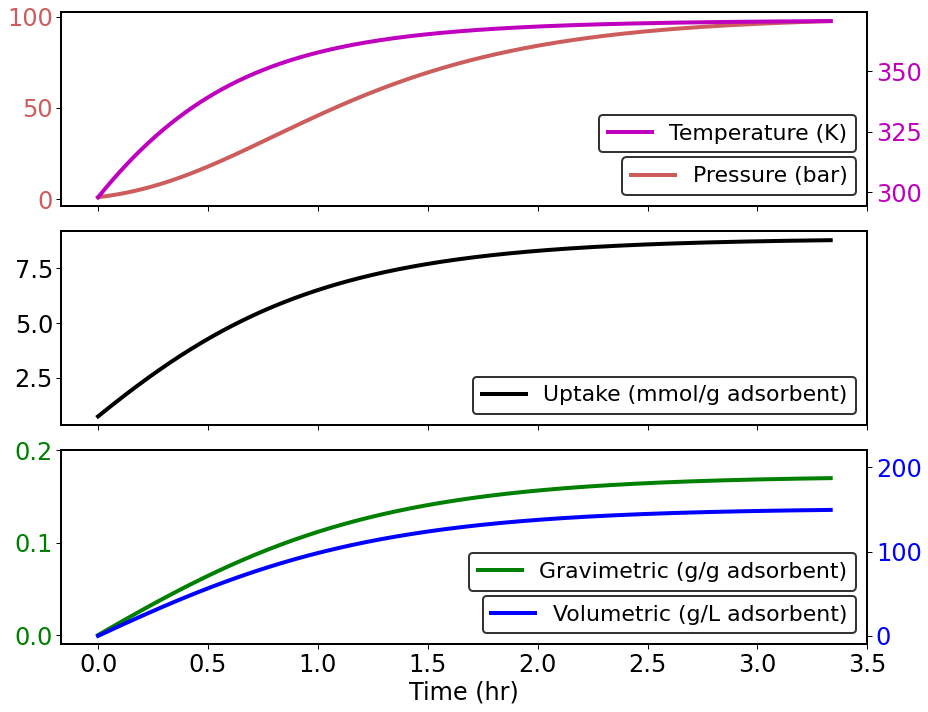

In [8]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(13, 10))

axs[0].plot(t_test/3600, P_res, label='Pressure (bar)', linewidth=4, color='indianred')

ax_twin_1 = axs[0].twinx()
ax_twin_1.tick_params(axis='both', width=1, length=5, labelcolor='m')
ax_twin_1.plot(t_test/3600, T_res, label='Temperature (K)', linewidth=4, color='m')

axs[1].plot(t_test/3600, q_res, label='Uptake (mmol/g adsorbent)', linewidth=4, color='k')

axs[2].plot(t_test/3600, sto_mass, label='Gravimetric (g/g adsorbent)', linewidth=4, linestyle='-', color='green')
axs[2].set_ylim(-0.01, 0.20)

ax_twin = axs[2].twinx()
ax_twin.plot(t_test/3600, sto_volume, label='Volumetric (g/L adsorbent)', linewidth=4, color='blue')
ax_twin.tick_params(axis='both', width=1, length=5, labelcolor='blue')
ax_twin.set_ylim(-10, 220)

axs[0]. tick_params(axis='x', width=1, length=5)
axs[0]. tick_params(axis='y', width=1, length=5, labelcolor='indianred')
axs[1]. tick_params(axis='both', width=1, length=5)
axs[2]. tick_params(axis='x', width=1, length=5)
axs[2]. tick_params(axis='y', width=1, length=5, labelcolor='green')

leg=ax_twin_1.legend(frameon=True, fontsize=22, loc='lower right', bbox_to_anchor=(1, 0.22))
leg.get_frame_on()
leg.get_frame().set_linewidth(2)
leg.get_frame().set_edgecolor('black')

leg=axs[0].legend(frameon=True, fontsize=22, loc='lower right')
leg.get_frame_on()
leg.get_frame().set_linewidth(2)
leg.get_frame().set_edgecolor('black')

leg1=axs[1].legend(frameon=True, fontsize=22, loc='lower right')
leg1.get_frame_on()
leg1.get_frame().set_linewidth(2)
leg1.get_frame().set_edgecolor('black')

leg2=axs[2].legend(frameon=True, fontsize=22, loc='lower right', bbox_to_anchor=(1, 0.22))
leg2.get_frame_on()
leg2.get_frame().set_linewidth(2)
leg2.get_frame().set_edgecolor('black')

leg3=ax_twin.legend(frameon=True, fontsize=22, loc='lower right')
leg3.get_frame_on()
leg3.get_frame().set_linewidth(2)
leg3.get_frame().set_edgecolor('black')

for axis in ['top','bottom','left','right']:
    axs[0].spines[axis].set_linewidth(2)
    axs[1].spines[axis].set_linewidth(2)
    axs[2].spines[axis].set_linewidth(2)

plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)

axs[2].set_xlabel('Time (hr)', fontsize=24)

plt.tight_layout()
plt. savefig(f"AST_example_{ads}.png",format='png', dpi=400)
plt.show()